Importing Libraries

In [ ]:
from scipy.io import loadmat
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.linalg import eig

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Reading The Dataset

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Brain-Computer Interfaces/Motor Imagery Dataset/'
mat = loadmat(DATASET_PATH + 'data_set_IVa_al.mat') 

In [ ]:
cnt = mat['cnt'] * 0.1
mrk = mat['mrk']
nfo = mat['nfo']
x = [each[0] for each in nfo['xpos'][0][0]]
y = [each[0] for each in nfo['ypos'][0][0]]
trials = mrk[0][0][0][0]
labels = mrk[0][0][1][0]
fs = nfo['fs'][0][0][0][0]
channels = [each[0] for each in nfo['clab'][0][0][0]]
channel_poses = [[x[i], y[i]] for i in range(len(x))]
# label_names = [each[0] for each in nfo['classes'][0][0][0]]
print('cnt.shape', cnt.shape)
print('trials', trials[:10], 'trials.shape', trials.shape)
print('labels', labels[:10], 'labels.shape', labels.shape)
print('fs', fs)
print('channels', channels)
# print('label_names', label_names)

cnt.shape (283574, 118)
trials [ 5171  5748  7385  9083  9623 10183 10763 12448 13006 13547] trials.shape (280,)
labels [1. 1. 2. 1. 1. 1. 2. 2. 1. 2.] labels.shape (280,)
fs 100
channels ['Fp1', 'AFp1', 'Fpz', 'AFp2', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'FAF5', 'FAF1', 'FAF2', 'FAF6', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FFC7', 'FFC5', 'FFC3', 'FFC1', 'FFC2', 'FFC4', 'FFC6', 'FFC8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'PCP7', 'PCP5', 'PCP3', 'PCP1', 'PCP2', 'PCP4', 'PCP6', 'PCP8', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PPO7', 'PPO5', 'PPO1', 'PPO2', 'PPO6', 'PPO8', 'PO7', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO8', 'OPO1', 'OPO2', 'O1', 'Oz', 'O

In [ ]:
def plot_magnitude_spectrum(sig, sr, title='signal', color='b'):
    n = len(sig)
    rf = np.linspace(0, sr / 2, num=round(n/2))
    fx = np.fft.fft(sig)
    fx = fx[:round(len(sig)/2)]                 # select half of all coeficients 
    fx = np.absolute(fx)                        # caculate magnitudes
    plt.figure(figsize=(18, 5))
    plt.plot(rf, fx, color=color)
    plt.xlabel('Frequency (Hz)')
    plt.title(title)
    plt.show()

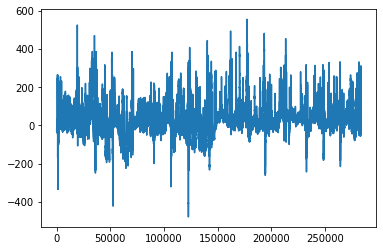

In [ ]:
plt.plot(cnt[:, 0])
plt.show()

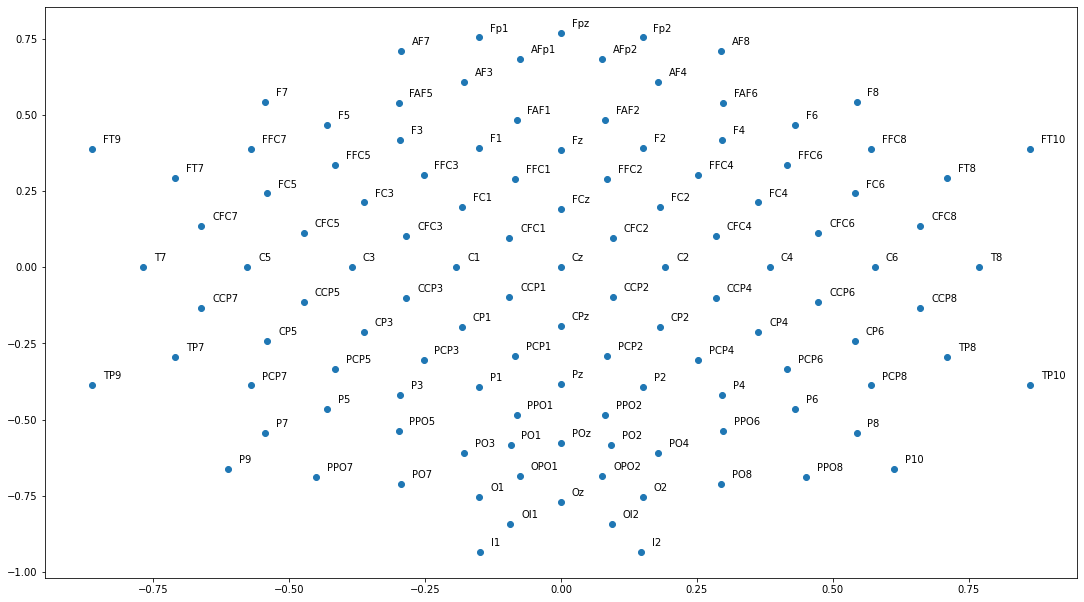

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(x, y)

for i, channel_name in enumerate(channels):
    ax.annotate(channel_name, (x[i] + 0.02, y[i] + 0.02))

Source Localization - Common Average Reference (CAR)


In [ ]:
def car_filter(cnt):
    ref = np.mean(cnt, axis=1)
    cnt_localized = cnt - np.mean(cnt, axis=1).reshape((cnt.shape[0], 1))
    return cnt_localized

cnt_localized = car_filter(cnt)
cnt.shape

(283574, 118)

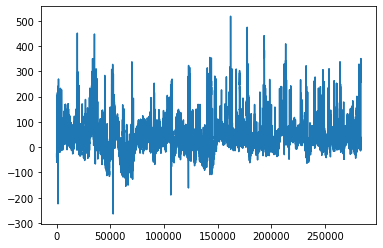

In [ ]:
plt.plot(cnt_localized[:, 0])
plt.show()

Source Localization - laplacian filter



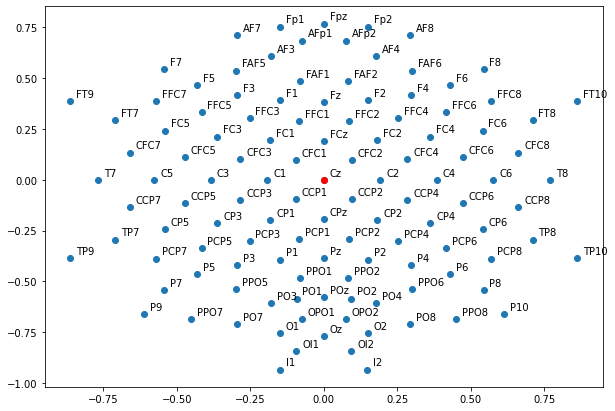

In [ ]:
ci = [0, 0]

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.scatter(x, y)
ax.scatter(ci[0], ci[1], color='r')

for i, channel_name in enumerate(channels):
    ax.annotate(channel_name, (x[i] + 0.02, y[i] + 0.02))

In [ ]:
def calculate_euclidean_distance(channel_poses, ci):
    distances = []
    for i in range(len(channel_poses)):
        score = np.sqrt(sum((np.array(channel_poses[i]) - np.array(ci)) ** 2))
        distances.append([i, score])    
        
    return sorted(distances, key=lambda x: x[1])[1:]

channel_poses = [[x[i], y[i]] for i in range(len(x))]
dis = calculate_euclidean_distance(channel_poses, ci)
dis[:10]

[[44, 0.13554223836628007],
 [45, 0.13554223836628007],
 [61, 0.13554223836628007],
 [62, 0.13554223836628007],
 [35, 0.1923076923076923],
 [52, 0.1923076923076923],
 [54, 0.1923076923076923],
 [71, 0.1923076923076923],
 [34, 0.2683736308540089],
 [36, 0.2683736308540089]]

In [ ]:
def find_laplacian_neighbours(channel_poses, dis, mode):
    if mode == 'low':
        cuton, cutoff = 0, 8
    elif mode == 'high':
        cuton, cutoff = 10, 22
    low_laplacian_neighbours_candidates = []
    for i, each in enumerate(channel_poses):
        for idx, d in dis[cuton:cutoff]:
            if i == idx:
                low_laplacian_neighbours_candidates.append(each + [d, idx])
                break

    for i in range(len(low_laplacian_neighbours_candidates)):
        cand_x, cand_y, d, idx = low_laplacian_neighbours_candidates[i]
        x_dis = np.sqrt((float(cand_x) - ci[0]) ** 2)
        y_dis = np.sqrt((float(cand_y) - ci[1]) ** 2)
        low_laplacian_neighbours_candidates[i] += [x_dis, y_dis]
    
    x_sorted = sorted(low_laplacian_neighbours_candidates, key = lambda x: x[-2])
    y_sorted = sorted(low_laplacian_neighbours_candidates, key = lambda x: x[-1])
    
    low_laplacian_neighbours = x_sorted[:2] + y_sorted[:2]
    return [each[:4] for each in low_laplacian_neighbours]
    

low_laplacian_neighbours = find_laplacian_neighbours(channel_poses, dis, mode='low')
low_laplacian_neighbours

[[0.0, 0.1923076923076923, 0.1923076923076923, 35],
 [0.0, -0.1923076923076923, 0.1923076923076923, 71],
 [-0.1923076923076923, 0.0, 0.1923076923076923, 52],
 [0.1923076923076923, 0.0, 0.1923076923076923, 54]]

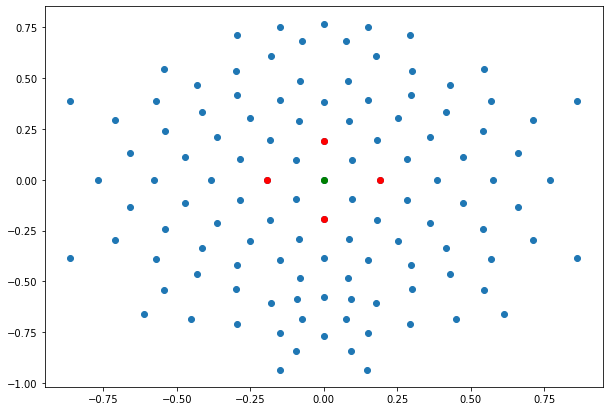

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.scatter([x[0] for x in channel_poses], [x[1] for x in channel_poses])
ax.scatter(ci[0], ci[1], color='g')
for each in low_laplacian_neighbours:
    ax.scatter(each[0], each[1], color='r')
plt.show()

In [ ]:
def calculate_neighbour_score(neighbours):
    neighbours = np.array(neighbours)
    d = neighbours[:, 2]
    w = (1 / d) / sum(1 / d)
    indices = [int(each) for each in neighbours[:, -1]]
    cnt_neighbours = cnt[:, indices] * w
    s = np.sum(cnt_neighbours, axis=1)
    cnt_final = cnt[:, 28] - s
    return cnt_final.shape

calculate_neighbour_score(low_laplacian_neighbours)

(283574,)

In [ ]:
def calculate_euclidean_distance(channel_poses, ci):
    distances = []
    for i in range(len(channel_poses)):
        score = np.sqrt(sum((np.array(channel_poses[i]) - np.array(ci)) ** 2))
        distances.append([i, score])    
        
    return sorted(distances, key=lambda x: x[1])[1:]


def find_laplacian_neighbours(channel_poses, dis, mode):
    if mode == 'low':
        cuton, cutoff = 0, 8
    elif mode == 'high':
        cuton, cutoff = 10, 22
    low_laplacian_neighbours_candidates = []
    for i, each in enumerate(channel_poses):
        for idx, d in dis[cuton:cutoff]:
            if i == idx:
                low_laplacian_neighbours_candidates.append(each + [d, idx])
                break

    for i in range(len(low_laplacian_neighbours_candidates)):
        cand_x, cand_y, d, idx = low_laplacian_neighbours_candidates[i]
        x_dis = np.sqrt((float(cand_x) - ci[0]) ** 2)
        y_dis = np.sqrt((float(cand_y) - ci[1]) ** 2)
        low_laplacian_neighbours_candidates[i] += [x_dis, y_dis]
    
    x_sorted = sorted(low_laplacian_neighbours_candidates, key = lambda x: x[-2])
    y_sorted = sorted(low_laplacian_neighbours_candidates, key = lambda x: x[-1])
    
    low_laplacian_neighbours = x_sorted[:2] + y_sorted[:2]
    return [each[:4] for each in low_laplacian_neighbours]


def calculate_neighbour_score(neighbours):
    neighbours = np.array(neighbours)
    d = neighbours[:, 2]
    w = (1 / d) / sum(1 / d)
    indices = [int(each) for each in neighbours[:, -1]]
    cnt_neighbours = cnt[:, indices] * w
    s = np.sum(cnt_neighbours, axis=1)
    cnt_final = cnt[:, 28] - s
    return cnt_final


def laplacian_filter(ch_names, mode='low'):
    laplaced_channels = []
    for each in ch_names:
        channel_idx = channels.index(each)
        ci = [x[channel_idx], y[channel_idx]]
        dis = calculate_euclidean_distance(channel_poses, ci)
        low_laplacian_neighbours = find_laplacian_neighbours(channel_poses, dis, mode=mode)
        laplaced_channels.append(calculate_neighbour_score(low_laplacian_neighbours))
    return np.array(laplaced_channels).T

In [ ]:
cnt_laplacian = laplacian_filter(channels)
cnt_laplacian.shape

(283574, 118)

In [ ]:
cnt_laplacian.shape; cnt_localized.shape

(283574, 118)

Bandpass Filter (8-30)

In [ ]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.filtfilt(b, a, data)
    return y

In [ ]:
cnt_banded = butter_bandpass_filter(cnt_localized, 8, 30, fs, 3)
cnt_banded.shape

(283574, 118)

Trial Extraction

In [ ]:
left_trials, foot_trials = np.zeros((400, 118, 112)), np.zeros((400, 118, 112))
c1, c2 = 0, 0

for i in range(len(trials)):
    trial_signal = np.array(cnt_banded[trials[i]:trials[i] + 400, :])
    if labels[i] == 1:
        left_trials[:, :, c1] = trial_signal
        c1 += 1
    elif labels[i] == -1:    
        foot_trials[:, :, c2] = trial_signal
        c2 += 1

left_trials, foot_trials = np.array(left_trials), np.array(foot_trials)
left_trials.shape, foot_trials.shape

((400, 118, 112), (400, 118, 112))

Common Spatial Patterns Filter (CSP)

In [ ]:
def csp_filter(data1, data2, n):
    Rh = 0
    for i in range(data1.shape[2]):
        trial = data1[:, :, i].T
        trial -= np.mean(trial, axis=1).reshape((trial.shape[0], 1)) # Normalize Data  
        rh = (np.matmul(trial, trial.T)) / np.trace(np.matmul(trial, trial.T))
        Rh += rh
        
    Rh /= data1.shape[2] #calculating Rh mean

    Rf = 0
    for i in range(data2.shape[2]):
        trial = data2[:, :, i].T
        trial -= np.mean(trial, axis=1).reshape((trial.shape[0], 1)) # Normalize Data  
        rf = (np.matmul(trial, trial.T)) / np.trace(np.matmul(trial, trial.T))
        Rf += rf
    Rf /= data2.shape[2] #calculating Rf mean

    Rh = np.nan_to_num(Rh, nan=0, posinf=0, neginf=0)
    Rf = np.nan_to_num(Rf, nan=0, posinf=0, neginf=0)

    # generalized eigen value decomposition
    u, v = eig(a=Rh, b=Rf)
    v = np.diag(v)
    v = sorted([[counter, each] for counter, each in enumerate(v)], key = lambda x: x[1], reverse=True)
    tmp = np.zeros(u.shape[0])
    for i, each in enumerate(v):
        tmp[i] = u[each[0]]
    u = np.array(tmp)
    v = np.array([each[1] for each in v])
    w = list(u)[:n + 1] + list(u)[-1 * n:]
    return w, u, v

w, u, v = csp_filter(left_trials, foot_trials, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
w

[inf, inf, inf, inf, inf]

Channel Selection (T-TEST)

In [ ]:
def channel_specific_feature_extractor(inp):
    inp_features = []
    for i in range(inp.shape[2]):
        trial = inp[:, :, i]
        r = np.sqrt(np.mean(trial**2, axis=0))
        all_trial_features = np.array(list(r))
        inp_features.append(all_trial_features) 
    return np.array(inp_features).T

left_channel_features = channel_specific_feature_extractor(left_trials)
foot_channel_features = channel_specific_feature_extractor(foot_trials)
left_channel_features.shape, foot_channel_features.shape

In [ ]:
Ts, Ps = [], []
for i in range(left_channel_features.shape[0]):
    Xa = left_channel_features[i, :]
    Xb = foot_channel_features[i, :]
    t, p = ttest_ind(Xa, Xb)
    Ts.append(t)
    Ps.append(p)

plt.plot(Ps)
plt.show()

In [ ]:
Ps_sorted = sorted([[i, Ps[i]] for i in range(len(Ps)) if str(Ps[i]) != 'nan'], key = lambda x: x[1])
plt.plot([each[1] for each in Ps_sorted])
plt.show()

In [ ]:
number_of_channels = 20
top_channels = [each[0] for each in Ps_sorted[:number_of_channels]]
top_channels

Feature Extraction

In [ ]:
def feature_extractor(inp):
    inp_features = []
    for i in range(inp.shape[2]):
        trial = inp[:, top_channels, i]
        m = np.mean(trial, axis=0)
        v = np.var(trial, axis=0)
        p = np.mean(trial ** 2, axis=0)
        r = np.sqrt(np.mean(trial**2, axis=0))
        all_trial_features = np.array(list(m) + list(v) + list(p) + list(r))
        inp_features.append(all_trial_features) 
    return np.array(inp_features).T

left_features = feature_extractor(left_trials)
foot_features = feature_extractor(foot_trials)
left_features.shape, foot_features.shape

In [ ]:
X = list(left_features.T) + list(foot_features.T)
y = [0] * left_features.T.shape[0] + [1] * foot_features.T.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
print(len(X), len(y))
print(len(X_train), len(y_train), len(X_test), len(y_test))

Classification

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

K-FOLD

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=5, random_state=1, shuffle=True)
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f' % (np.mean(scores)))